This file uses the premade vector data frame that Rishabh created (for computational efficiency). Not generating vectors manually in this file. Vectors being used will be consistent.

Also, in this file everything is being run on all nodes/vectors (no subgraphs)

TRAINING

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import pandas as pd
import numpy

import math

import os
import random
# from gensim.models import Word2Vec
import networkx as nx
import seaborn as sns

# from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc, log_loss, RocCurveDisplay


In [3]:
node_df = pd.read_csv("2024_05_05_meta_node_data.csv")
edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")
vector_df = pd.read_csv("df_node_embeddings_dim128_p0.5_q0.5_walk20_n_walks8_wlks_p_node100_cntxt10 (1).csv")
geneGraph = nx.DiGraph()
# %run vizfunctions.ipynb
node_df.set_index('id',inplace=True)
node_df.head()

/var/folders/6q/0qnxsny943385fwzz738241c0000gn/T/ipykernel_42096/364345071.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  edge_df = pd.read_csv("2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")


,symbol,disease_assoc_cat,publication_count,ortholog_count,all_ortho_count
id,,,,,
7414,VCL,disease_assoc,279,5,"{'hsapien': {'entrezid': 7414, 'symbol': 'VCL'..."
4626,MYH8,disease_assoc,36,4,"{'hsapien': {'entrezid': 4626, 'symbol': 'MYH8..."
9722,NOS1AP,disease_assoc,141,5,"{'hsapien': {'entrezid': 9722, 'symbol': 'NOS1..."
9891,NUAK1,non_disease_assoc,70,5,"{'hsapien': {'entrezid': 9891, 'symbol': 'NUAK..."
81788,NUAK2,disease_assoc,46,2,"{'hsapien': {'entrezid': 81788, 'symbol': 'NUA..."


In [4]:
# Removing non_omim nodes
all_node_ids = []
for id in vector_df["id"]:
    all_node_ids.append(id)

int_node_ids = []
non_omim_ids = []
for id in all_node_ids:
    if node_df.loc[id]["disease_assoc_cat"] == "disease_assoc" or node_df.loc[id]["disease_assoc_cat"] == "non_disease_assoc":
        int_node_ids.append(id)
    elif node_df.loc[id]["disease_assoc_cat"] == "non_omim":
        non_omim_ids.append(id)

print(len(int_node_ids))
        

16220


In [5]:
# Removing non_omim nodes from df
non_omim_rows = vector_df[vector_df["id"].isin(non_omim_ids)]

training_vector_df = vector_df.drop(non_omim_rows.index)

training_vector_df.head()
print(len(training_vector_df))

16220


In [5]:
vector_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,id
0,0,0.064558,-0.051640,-0.083797,0.062531,0.057180,0.014313,-0.052380,-0.103716,-0.015086,...,-0.007501,0.089192,-0.038257,-0.087094,0.034081,-0.069049,-0.071937,-0.055029,0.016416,7414
1,1,0.070410,-0.065505,-0.216953,-0.149399,-0.122614,-0.070443,0.028499,0.004111,-0.066796,...,0.084825,-0.092645,0.027228,0.032798,-0.143785,0.037345,-0.053298,0.003609,-0.092844,4626
2,2,0.070818,-0.080974,0.073398,-0.015023,-0.000077,-0.008002,-0.082583,-0.038015,0.044983,...,0.023089,-0.017646,0.096217,0.053226,0.070061,0.027838,-0.035029,0.055155,-0.056974,9722
3,3,0.107021,0.013994,0.036538,-0.063050,-0.086183,0.043723,0.145028,0.103949,0.036598,...,0.065681,0.009408,0.026440,-0.059795,0.049326,-0.024846,-0.041913,-0.001121,0.005391,9891
4,4,-0.392722,0.441372,0.236662,-0.245315,-0.104067,0.292547,-0.161585,-0.018632,0.061402,...,-0.021892,0.242594,-0.414570,0.134470,-0.121044,-0.388935,-0.150884,-0.295264,-0.248610,81788


In [8]:
# Data preprocessing

# Creating a dataset with just the genes, classification, and vectors
# vector_data = pd.DataFrame(vectors)
disease_assoc_cat = numpy.array([node_df.loc[node_id]['disease_assoc_cat'] for node_id in int_node_ids])
publication_count = numpy.array([node_df.loc[node_id]['publication_count'] for node_id in int_node_ids])
ortholog_count = numpy.array([node_df.loc[node_id]['ortholog_count'] for node_id in int_node_ids])
all_ortho_count = numpy.array([node_df.loc[node_id]['all_ortho_count'] for node_id in int_node_ids])


training_vector_df['gene'] = int_node_ids
# vector_data['publication count'] = publication_count
# vector_data['ortholog_count'] = ortholog_count
# vector_data['all_ortho_count'] = all_ortho_count
training_vector_df['disease_assoc_cat'] = disease_assoc_cat

training_vector_df.set_index('gene',inplace=True)

# Creating features
X = training_vector_df.iloc[:, :-1].values    # Taking vectors as input
y = training_vector_df['disease_assoc_cat'].values  # Taking disease association as output

# Splitting data
X_training, X_test, y_training, y_test = train_test_split(X, y, train_size = 0.9, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, train_size = 0.8, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
label_mapping = {
    'non_disease_assoc': 0,
    'disease_assoc': 1,
    'non_omim': 2
}

y_train= [label_mapping[value] for value in y_train]
y_val= [label_mapping[value] for value in y_val]
y_test= [label_mapping[value] for value in y_test]


In [8]:
# Linear SVC
# Initiatlize classifier
svm_model = LinearSVC()

# Perform cross-validation
linear_cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", linear_cv_scores)
print("Mean cross-validation accuracy:", linear_cv_scores.mean())

# Train classifier
svm_model.fit(X_train_scaled, y_train)

# Evaluating classifier
linear_accuracy = svm_model.score(X_test_scaled, y_test)
print(f'Accuracy: {linear_accuracy}')

# Confusion matrix
y_pred = svm_model.predict(X_test_scaled)
linear_cm = confusion_matrix(y_test, y_pred)
print(linear_cm)

lin_svc_train_acc = svm_model.score(X_train, y_train)
print("Training accuracy:", lin_svc_train_acc)

#    vector size       edges    nodes       other features           accuracy               (geneGraph, 50, 10, 0.5, 0.5)
#         128         100000   ~9400            none            0.6232114467408585
#         128         100000   ~9400    pub_count, ortho count  0.3783783783783784
#         512         100000   ~9400            none            0.6063492063492063
#         512         100000   ~9400    pub_count, ortho count  0.3904761904761905
#         64          100000   ~9400            none            0.617879746835443
#         64          100000   ~9400    pub_count, ortho count  0.35917721518987344
#         256         100000   ~9400            none            0.6232227488151659
#         32          100000   ~9400            none            0.6195393169181891


#    vector size       edges      nodes       random walk               accuracy               
#         128          100000     ~9400     (50, 10, 0.5, 0.5)       0.6232114467408585
#         256          100000     ~9400     (50, 10, 0.5, 0.5)       0.6232227488151659
#         512          100000     ~9400     (50, 10, 0.5, 0.5)       0.6063492063492063
#         64           100000     ~9400     (50, 10, 0.5, 0.5)       0.617879746835443

#         64           100000     ~9400     (50, 10, 0.8, 0.4)       0.6283676703645008
#         128          100000     ~9400     (50, 10, 0.8, 0.4)       0.6313291139240507
#         256          100000     ~9400     (50, 10, 0.8, 0.4)       0.6313291139240507
#         512          100000     ~9400     (50, 10, 0.8, 0.4)       0.6006314127861089

#         64           100000     ~9400     (50, 10, 0.4, 0.8)       0.6304868316041501
#         128          100000     ~9400     (50, 10, 0.4, 0.8)       0.6282051282051282
#         256          100000     ~9400     (50, 10, 0.4, 0.8)       0.608
#         512          100000     ~9400     (50, 10, 0.4, 0.8)       0.6142172523961661

#         512          100000     ~9400     (50, 10, 1, 0.2)         0.629222309505106

# ~2 seconds to run

Cross-validation accuracies: [0.70376712 0.70119863 0.70119863 0.70119863 0.70633562 0.70376712
 0.70547945 0.70633562 0.70437018 0.70094259]
Mean cross-validation accuracy: 0.7034593589698442
Accuracy: 0.7071516646115906
[[   2  473]
 [   2 1145]]
Training accuracy: 0.7039732830964206


In [9]:
# Kernel SVC

# Initialize classifier
kernelsvc_model = SVC()

# Perform cross-validation
kernel_cv_scores = cross_val_score(kernelsvc_model, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", kernel_cv_scores)
print("Mean cross-validation accuracy:", kernel_cv_scores.mean())

# Train classifier
kernelsvc_model.fit(X_train_scaled, y_train)

# Evaluating classifier
kernel_accuracy = kernelsvc_model.score(X_test_scaled, y_test)
print(f'Accuracy: {kernel_accuracy}')

# Confusion matrix
y_pred = kernelsvc_model.predict(X_test_scaled)
kernel_cm = confusion_matrix(y_test, y_pred)
print(kernel_cm)

# Training accuracy
svc_train_acc = kernelsvc_model.score(X_train, y_train)
print("Training accuracy:", svc_train_acc)
#~2 min to run

Cross-validation accuracies: [0.70462329 0.70376712 0.70376712 0.70376712 0.70376712 0.70462329
 0.70462329 0.70376712 0.70351328 0.70437018]
Mean cross-validation accuracy: 0.7040588941320092
Accuracy: 0.7065351418002466
[[   0  475]
 [   1 1146]]
Training accuracy: 0.7039732830964206


In [10]:
# Random forest classifier

# Initiatlize classifier
random_forest_classifier = RandomForestClassifier()

# Perform cross-validation
rfc_cv_scores = cross_val_score(random_forest_classifier, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", rfc_cv_scores)
print("Mean cross-validation accuracy:", rfc_cv_scores.mean())

# Train classifier
random_forest_classifier.fit(X_train_scaled, y_train)

# Evaluating classifier
rfc_accuracy = random_forest_classifier.score(X_test_scaled, y_test)
print(f'Accuracy: {rfc_accuracy}')

# Confusion matrix
y_pred = random_forest_classifier.predict(X_test_scaled)
rfc_cm = confusion_matrix(y_test, y_pred)
print(rfc_cm)

# Training accuracy
rfc_training_acc = random_forest_classifier.score(X_train, y_train)
print("Training accuracy:", rfc_training_acc)
#~4 min to run

Cross-validation accuracies: [0.6994863  0.6994863  0.69691781 0.70291096 0.70119863 0.70119863
 0.69520548 0.70376712 0.69837189 0.70008569]
Mean cross-validation accuracy: 0.699862881642427
Accuracy: 0.7127003699136868
[[  26  449]
 [  17 1130]]
Training accuracy: 0.7039732830964206


In [11]:
# k-nearest neighbors classifier

# Initialize classifier
KNN = KNeighborsClassifier()

# Perform cross-validation
knn_cv_scores = cross_val_score(KNN, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", knn_cv_scores)
print("Mean cross-validation accuracy:", knn_cv_scores.mean())

# Train classifier
KNN.fit(X_train_scaled, y_train)

# Evaluating classifier
knn_accuracy = KNN.score(X_test_scaled, y_test)
print(f'Accuracy: {knn_accuracy}')

# Confusion matrix
y_pred = KNN.predict(X_test_scaled)
knn_cm = confusion_matrix(y_test, y_pred)
print(knn_cm)

# Training accuracy
knn_training_acc = KNN.score(X_train, y_train)
print("Training accuracy:", knn_training_acc)
#~2 min to run



Cross-validation accuracies: [0.63613014 0.65496575 0.64212329 0.61986301 0.65496575 0.62243151
 0.65410959 0.63184932 0.63581834 0.64524422]
Mean cross-validation accuracy: 0.6397500909720512
Accuracy: 0.6436498150431565
[[ 91 384]
 [194 953]]
Training accuracy: 0.7039732830964206


#### Alex training changes

In [14]:
# Data preprocessing

# Creating a dataset with just the genes, classification, and vectors
# vector_data = pd.DataFrame(vectors)
disease_assoc_cat = numpy.array([node_df.loc[node_id]['disease_assoc_cat'] for node_id in int_node_ids])
publication_count = numpy.array([node_df.loc[node_id]['publication_count'] for node_id in int_node_ids])
ortholog_count = numpy.array([node_df.loc[node_id]['ortholog_count'] for node_id in int_node_ids])
all_ortho_count = numpy.array([node_df.loc[node_id]['all_ortho_count'] for node_id in int_node_ids])


training_vector_df['gene'] = int_node_ids
# vector_data['publication count'] = publication_count
# vector_data['ortholog_count'] = ortholog_count
# vector_data['all_ortho_count'] = all_ortho_count
training_vector_df['disease_assoc_cat'] = disease_assoc_cat

training_vector_df.set_index('gene',inplace=True)

# Creating features
X = training_vector_df.iloc[:, 2:-1].values    # Taking vectors as input
#y = training_vector_df['disease_assoc_cat'].values
y = (training_vector_df['disease_assoc_cat'] == 'disease_assoc').astype(int).values  # non_disease 0, disease 1

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, train_size = 0.8, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape) 
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12976, 130)
X_test shape: (3244, 130)
y_train shape: (12976,)
y_test shape: (3244,)


In [8]:
# Before fitting, let's check class distribution
from collections import Counter
print("Class distribution in training set:", Counter(y_train))

Class distribution in training set: Counter({np.int64(0): 9140, np.int64(1): 3836})


Basic logistic regression model


Logistic Regression Scores:
Training Score: 0.543
Test Score: 0.491

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.51      0.59      2284
           1       0.30      0.49      0.37       960

    accuracy                           0.51      3244
   macro avg       0.50      0.50      0.48      3244
weighted avg       0.59      0.51      0.53      3244

Cross-Validation Recall: 0.501 ± 0.011


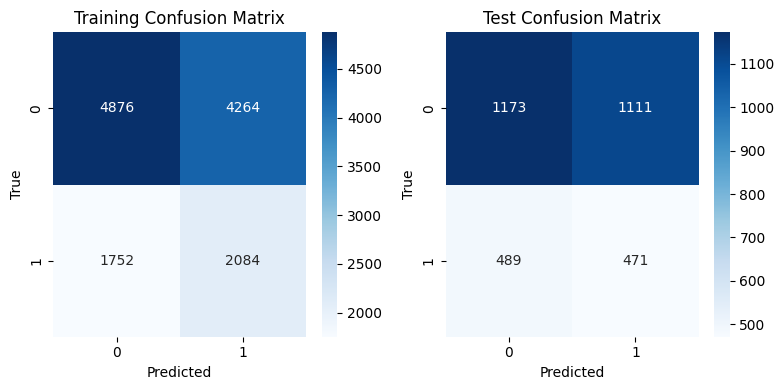

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

# Initialize LogisticRegressionCV with balanced class weights and adjusted parameters
logreg_cv = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    scoring='recall',           # Changed from accuracy to f1 to better handle imbalance
    class_weight='balanced', # Add class weights to handle imbalance
    n_jobs=-1              # Use all available cores
)

# Fit the model using the original training data
logreg_cv.fit(X_train, y_train)

# Get training and test scores
logreg_train_score = logreg_cv.score(X_train, y_train)
logreg_test_score = logreg_cv.score(X_test, y_test)
print("\nLogistic Regression Scores:")
print(f"Training Score: {logreg_train_score:.3f}")
print(f"Test Score: {logreg_test_score:.3f}")

# Get predictions and probabilities
y_pred = logreg_cv.predict(X_test)
y_pred_proba = logreg_cv.predict_proba(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Average Cross-Validated Recall
cv_recall = cross_val_score(logreg_cv, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='recall')
print(f"Cross-Validation Recall: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")

# Generate confusion matrices for both training and test sets
y_train_pred = logreg_cv.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_pred)

# Create subplots for training and test confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot test confusion matrix 
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Test Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

Support vector machine


SVC Scores:
Training Score: 0.751
Test Score: 0.537

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.58      0.64      2284
           1       0.30      0.43      0.35       960

    accuracy                           0.54      3244
   macro avg       0.50      0.50      0.50      3244
weighted avg       0.59      0.54      0.55      3244

Cross-Validation Recall: 0.441 ± 0.020


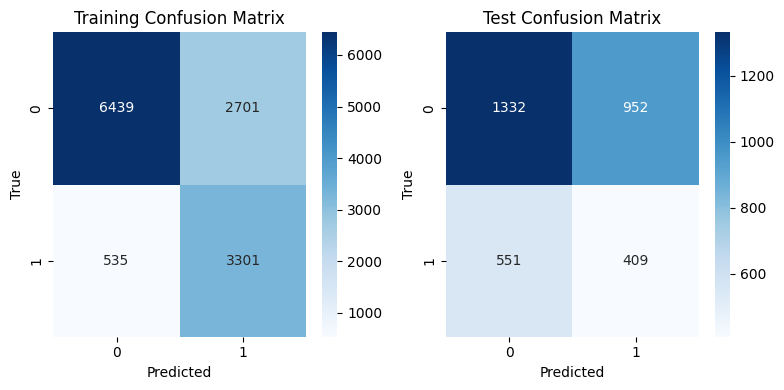

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Initialize SVC with balanced class weights and adjusted parameters
svc = SVC(
    C=1.0,
    kernel='rbf', 
    gamma='scale',
    random_state=42,
    probability=True,
    class_weight='balanced'  # Add class weights to handle imbalance
)

# Fit the model using the original training data
svc.fit(X_train, y_train)

# Get training and test scores
svc_train_score = svc.score(X_train, y_train)
svc_test_score = svc.score(X_test, y_test)
print("\nSVC Scores:")
print(f"Training Score: {svc_train_score:.3f}")
print(f"Test Score: {svc_test_score:.3f}")

# Get predictions and probabilities
y_pred = svc.predict(X_test)
y_pred_proba = svc.predict_proba(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Average Cross-Validated Recall
cv_recall = cross_val_score(svc, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='recall')
print(f"Cross-Validation Recall: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")

# Generate confusion matrices for both training and test sets
y_train_pred = svc.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_pred)

# Create subplots for training and test confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot test confusion matrix 
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Test Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

Random forest classifier [doesn't work]


Random Forest Scores:
Training Score: 1.000
Test Score: 0.700

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82      2284
           1       0.40      0.03      0.05       960

    accuracy                           0.70      3244
   macro avg       0.55      0.50      0.44      3244
weighted avg       0.61      0.70      0.59      3244



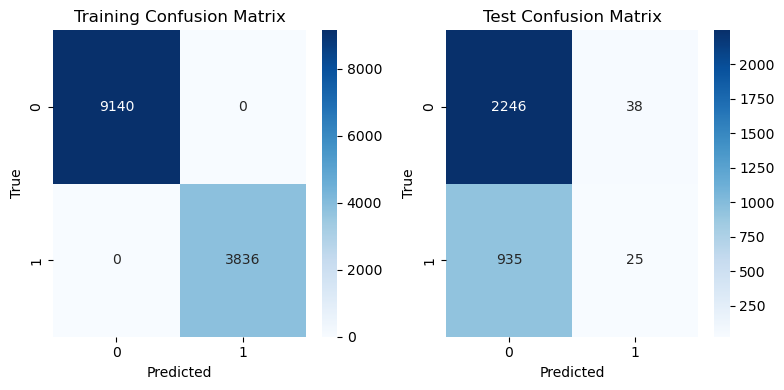


Top 10 Most Important Features:
     feature  importance
129      129    0.040812
0          0    0.033640
82        82    0.008380
29        29    0.007845
78        78    0.007823
77        77    0.007813
5          5    0.007782
88        88    0.007753
79        79    0.007668
102      102    0.007660


In [53]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with hyperparameters
rf = RandomForestClassifier(
    n_estimators=100,             # Number of trees in the forest
    max_depth=None,               # Maximum depth of trees
    min_samples_split=2,          # Minimum samples required to split node
    min_samples_leaf=1,           # Minimum samples required at leaf node
    random_state=42,
    n_jobs=-1,                     # Use all available cores
    class_weight='balanced'        # Account for class imbalance
)

# Fit the model using the training data
rf.fit(X_train, y_train)

# Get training and test scores
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print("\nRandom Forest Scores:")
print(f"Training Score: {rf_train_score:.3f}")
print(f"Test Score: {rf_test_score:.3f}")

# Get predictions and probabilities
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrices for both training and test sets
y_train_pred = rf.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_pred)

# Create subplots for training and test confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot test confusion matrix 
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Test Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': range(X_train.shape[1]),
    'importance': rf.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


KNN


KNN (k=1) Scores:
Training Score: 1.000
Test Score: 0.601

KNN (k=2) Scores:
Training Score: 0.798
Test Score: 0.673

KNN (k=3) Scores:
Training Score: 0.793
Test Score: 0.628

KNN (k=4) Scores:
Training Score: 0.755
Test Score: 0.668

KNN (k=5) Scores:
Training Score: 0.746
Test Score: 0.638

KNN (k=6) Scores:
Training Score: 0.735
Test Score: 0.669

KNN (k=7) Scores:
Training Score: 0.729
Test Score: 0.646

KNN (k=8) Scores:
Training Score: 0.723
Test Score: 0.674

KNN (k=9) Scores:
Training Score: 0.721
Test Score: 0.662

KNN (k=10) Scores:
Training Score: 0.718
Test Score: 0.680


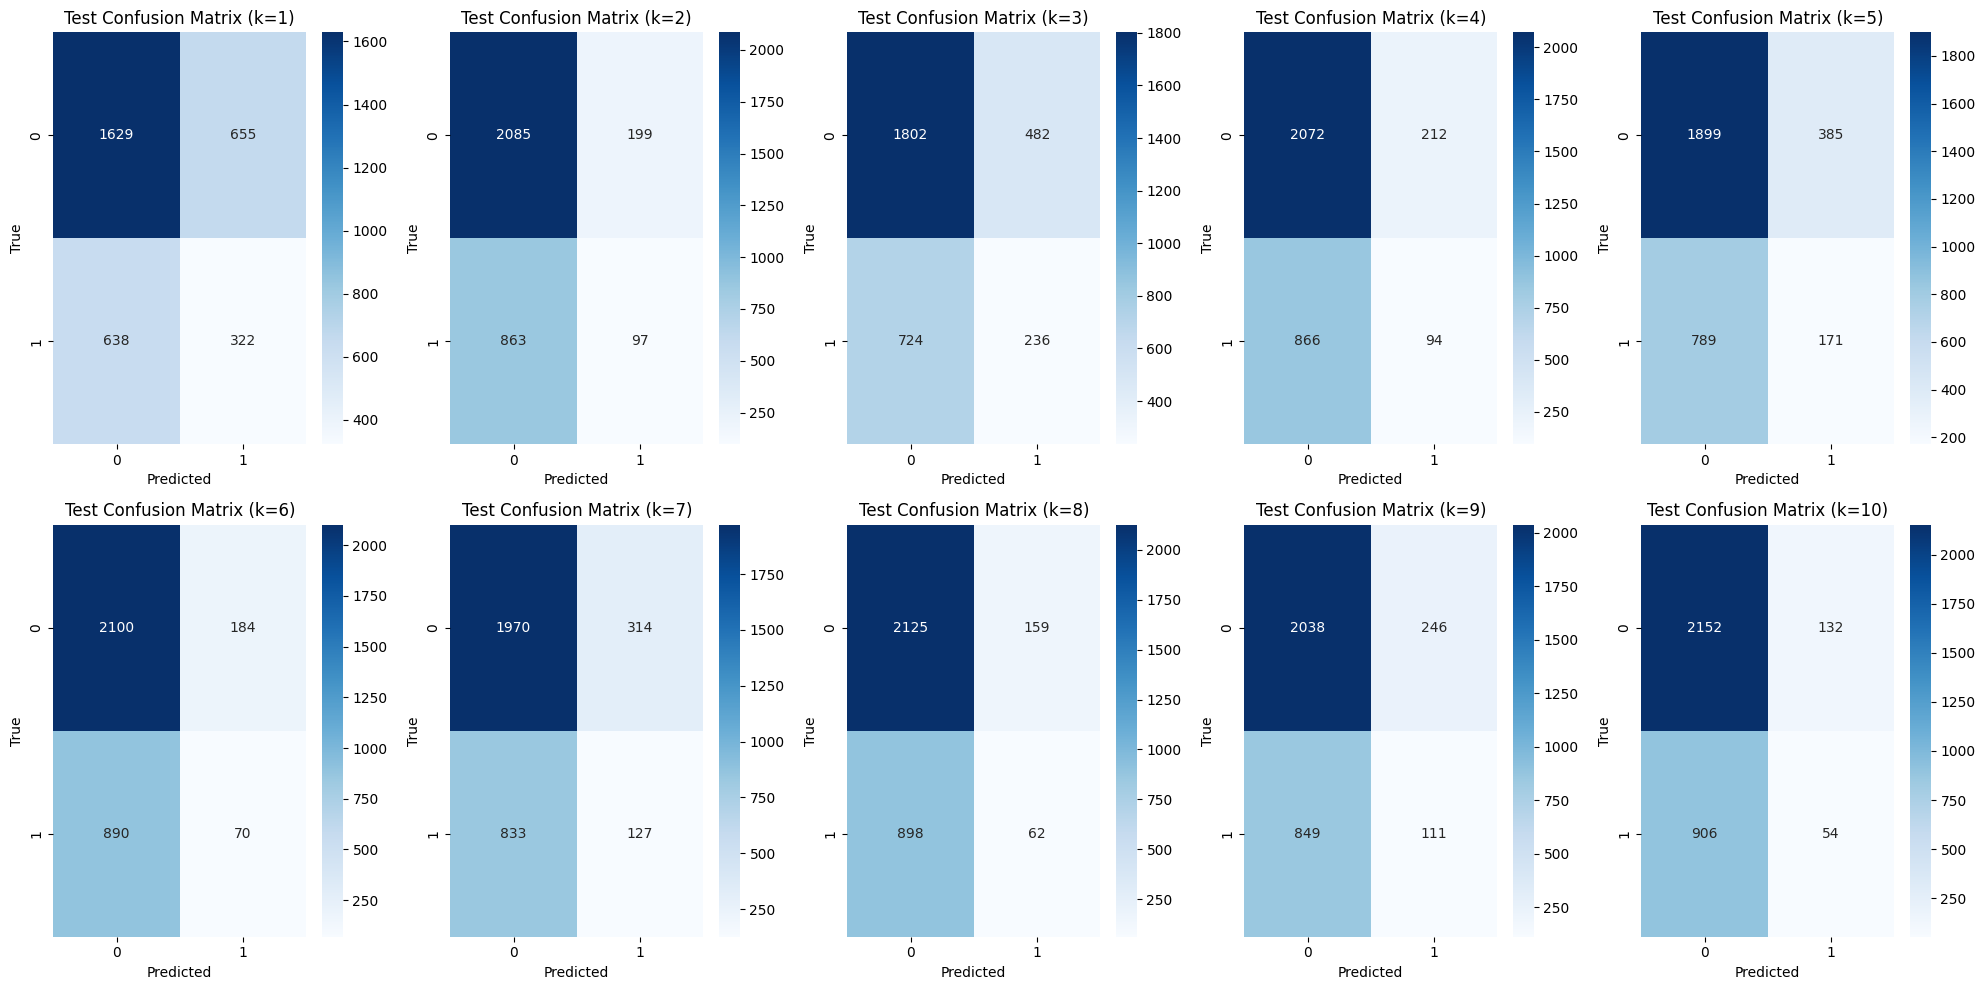


Best k=1 based on recall for disease class
Recall for disease class: 0.335

Full classification report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2284
           1       0.33      0.34      0.33       960

    accuracy                           0.60      3244
   macro avg       0.52      0.52      0.52      3244
weighted avg       0.60      0.60      0.60      3244

Cross-Validation Recall: 0.067 ± 0.009


In [22]:
import numpy as np
from sklearn.metrics import recall_score

# KNN with different numbers of neighbors
plt.figure(figsize=(20, 10))

for n in range(1, 11):
    # Create and train KNN model
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    
    # Get training and test scores
    knn_train_score = knn.score(X_train, y_train)
    knn_test_score = knn.score(X_test, y_test)
    
    print(f"\nKNN (k={n}) Scores:")
    print(f"Training Score: {knn_train_score:.3f}")
    print(f"Test Score: {knn_test_score:.3f}")
    
    # Get predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    # Generate confusion matrices
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    # Plot confusion matrices
    plt.subplot(2, 5, n)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test Confusion Matrix (k={n})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()
# Find best k based on recall for disease class (1)
recalls = []
k_values = range(1,11)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label=1)
    recalls.append(recall)

best_k = k_values[np.argmax(recalls)]

# Train final model with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

print(f"\nBest k={best_k} based on recall for disease class")
print(f"Recall for disease class: {recalls[best_k-1]:.3f}")
print("\nFull classification report:")
print(classification_report(y_test, y_pred))

# Average Cross-Validated Recall
cv_recall = cross_val_score(knn, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='recall')
print(f"Cross-Validation Recall: {cv_recall.mean():.3f} ± {cv_recall.std():.3f}")


#### Next steps
- Evaluate model performance using recall on training and testing sets. 
    - To evaluate which models we should 'trust' more, we will look at the recall for the disease class (save this for both training and testing sets for each model).
- Identify non-disease genes in test set that are classified as disease genes across all models.
    - Find the non-disease genes that are most frequently misclassified as disease genes. We are only looking for this in the testing set.
    - These are our candidate non-disease genes that may actually be disease genes.
    - This work flow serves as a proof of concept 'ensemble' approach for identifying non-disease genes that may actually be disease genes.

#### Results


In [17]:
# Isolating non_disease nodes
all_node_ids = []
for id in vector_df["id"]:
    all_node_ids.append(id)

int_node_ids = []
non_disease_ids = []
for id in all_node_ids:
    if node_df.loc[id]["disease_assoc_cat"] == "disease_assoc" or node_df.loc[id]["disease_assoc_cat"] == "non_omim":
        int_node_ids.append(id)
    elif node_df.loc[id]["disease_assoc_cat"] == "non_disease_assoc":
        non_disease_ids.append(id)

print(len(int_node_ids))

# Isolating non-disease node embeddings in a df
unknown_rows = vector_df[vector_df["id"].isin(int_node_ids)]

unknown_vector_df = vector_df.drop(unknown_rows.index)

print(len(unknown_vector_df))

8443
11424


In [50]:
# Data preprocessing

X = unknown_vector_df.iloc[:,1:-1]
print(len(X))

11424


In [59]:
print(unknown_vector_df.iloc[:,-1:])

              id
3           9891
5          83892
7          26608
10         65084
11         54842
...          ...
19845  100506548
19858     119395
19861       5548
19862      27004
19864     221393

[11424 rows x 1 columns]


In [73]:
# Predicting using logistic regressor

y_pred = logreg_cv.predict(X)
print(y_pred)

# Number of Candidate Genes
pos_list = []

for item in y_pred:
    if item == 1:
        pos_list.append(item)

print("Total number of genes:",len(list(y_pred)))
print("Number of Candidate genes:",len(pos_list),"\n")

# Specific Candidate Genes DataFrame
y_pred_df = pd.DataFrame(list(y_pred), columns=['disease association (1/0)'])
y_pred_df['id'] = unknown_vector_df['id'].values

# print(y_pred_df)

# Specific Candidate Genes List

logreg_cv_candidates = []

print("Candidate genes:")
for index, gene in y_pred_df.iterrows():
    if gene['disease association (1/0)'] == 1:
        print(gene['id'])
        logreg_cv_candidates.append(gene)

/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/envname/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


[1 0 1 ... 0 1 0]
Total number of genes: 11424
Number of Candidate genes: 3983 

Candidate genes:
9891
26608
54842
23428
8140
22920
5033
283208
5051
8394
9271
90459
51000
22803
57089
63979
573
113510
9212
93974
10963
10396
1610
80010
126549
7150
328
171017
864
5013
3170
1745
121549
4664
222894
5126
3357
10160
9855
5869
10207
599
8601
23526
85397
115703
9901
392
5536
23053
5609
1850
51035
54896
112483
140739
9057
978
389421
677
10595
3174
85313
4783
1388
83482
27164
9355
283150
1879
1628
51588
8554
4676
10212
3309
7027
29915
23318
3276
155368
10006
65059
8019
6627
9733
89832
3983
1266
1265
262
10487
4245
6540
6539
4048
57127
322
120114
260425
9033
5578
8536
4249
89872
27159
9497
51454
23063
475
79699
904
9134
84669
55611
115201
1473
1470
1469
8976
23411
1609
6564
23266
55124
6118
2043
1948
2173
85329
51735
118426
26230
4881
10724
9869
11105
10919
54665
4678
5931
5928
23235
1612
65975
55856
64395
11051
57120
8446
3611
10979
55177
93273
646486
51144
9058
5937
9444
26986
9520
56999
11096
1

SVC predicted almost all nondisease genes to be candidate genes

In [74]:
# Predicting using SVC
y_pred = svc.predict(X)
print(y_pred)

# Number of Candidate Genes
pos_list = []

for item in y_pred:
    if item == 1:
        pos_list.append(item)

print("Total number of genes:",len(list(y_pred)))
print("Number of Candidate genes:",len(pos_list),"\n")

# Specific Candidate Genes DataFrame
y_pred_df = pd.DataFrame(list(y_pred), columns=['disease association (1/0)'])
y_pred_df['id'] = unknown_vector_df['id'].values

# print(y_pred_df)

# Specific Candidate Genes List
svc_candidates = []

print("Candidate genes:")
for index, gene in y_pred_df.iterrows():
    if gene['disease association (1/0)'] == 1:
        print(gene['id'])
        svc_candidates.append(gene)

/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/envname/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


[1 1 1 ... 1 1 1]
Total number of genes: 11424
Number of Candidate genes: 11037 

Candidate genes:
9891
83892
26608
65084
54842
4811
23428
8140
3217
3203
3204
3223
3216
3222
10055
23309
22920
5033
283208
266743
7334
5051
5289
8394
9271
5136
90459
51000
93517
2529
167227
22803
10057
57089
9583
5563
10938
63979
9532
573
3337
113510
9212
93974
10963
10396
283927
1610
8528
192669
192670
139065
10987
80263
5602
5601
54514
150280
80010
405
126549
83940
7150
328
171017
26205
10691
864
7101
5013
3091
3171
3170
431707
1044
1045
6671
6670
1745
56676
121549
429
3975
64843
3670
4618
22809
468
6721
9079
4664
7534
222894
4825
10419
4800
4802
221656
5126
1128
350383
3357
9630
346562
83903
10160
9855
7264
2762
5870
5869
11021
4218
10890
161
9135
55604
10207
598
599
57584
8601
10287
55357
9411
23526
8786
9779
85397
5997
64407
6003
115703
85360
393
9901
391
5862
26052
392
11335
3005
4778
2288
5536
23053
5599
5609
1850
55968
51035
11124
54896
10238
1432
5608
389840
112483
222236
142
10038
140739
11254
26

k-NN predicted really few genes to be candidate genes

In [75]:
# Predicting using k-NN
y_pred = knn.predict(X)
print(y_pred)

# Number of Candidate Genes
pos_list = []

for item in y_pred:
    if item == 1:
        pos_list.append(item)

print("Total number of genes:",len(list(y_pred)))
print("Number of Candidate genes:",len(pos_list),"\n")

# Specific Candidate Genes DataFrame
y_pred_df = pd.DataFrame(list(y_pred), columns=['disease association (1/0)'])
y_pred_df['id'] = unknown_vector_df['id'].values

# print(y_pred_df)

# Specific Candidate Genes List
knn_candidates = []

print("Candidate genes:")
for index, gene in y_pred_df.iterrows():
    if gene['disease association (1/0)'] == 1:
        print(gene['id'])
        knn_candidates.append(gene)

/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/envname/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


[0 0 0 ... 0 0 0]
Total number of genes: 11424
Number of Candidate genes: 336 

Candidate genes:
22920
10057
10987
3357
7264
121643
9063
9033
9497
2079
3831
11127
342372
10343
2004
3326
320
90353
7323
54851
89958
23313
11079
6209
6202
64745
6188
51263
8649
84844
64332
55848
253980
11267
6184
84717
440574
116540
284325
25809
5434
5425
54729
7022
2119
1951
5905
64062
5229
1810
10652
10905
10941
3038
54878
54657
2987
1571
4682
552900
23198
8667
2242
7514
9972
115817
29062
23760
5198
56660
9467
55844
81605
84817
5636
327
2675
8774
54856
55122
84246
51386
6902
7328
26297
27339
85363
135892
2966
80258
51177
154141
3009
11317
94234
56252
3360
2207
5600
23406
79602
143458
6819
22933
57476
5802
84289
9612
161247
7430
170689
4759
9982
10052
6456
59277
1241
7247
359787
349565
50636
400629
9454
3304
129138
1845
685
493
10507
1649
23208
23466
9610
23648
55585
285671
135138
347732
148867
387357
441925
54891
252839
50486
128602
5653
3817
1039
10618
4608
10573
319101
84306
341116
60672
57692
114815
54

In [82]:
print(type(element) for element in svc_candidates)

<generator object <genexpr> at 0x16de7f920>


In [83]:
logreg_cv_candidates = [list(item) for item in logreg_cv_candidates]
svc_candidates = [list(item) for item in svc_candidates]
knn_candidates = [list(item) for item in knn_candidates]

# Debugging: Ensure the lists are now proper lists with actual values
print(type(logreg_cv_candidates), type(svc_candidates), type(knn_candidates))

# Print the first few elements of each list
print(f"Logreg Candidates: {logreg_cv_candidates[:2]}")
print(f"SVC Candidates: {svc_candidates[:2]}")
print(f"KNN Candidates: {knn_candidates[:2]}")

<class 'list'> <class 'list'> <class 'list'>
Logreg Candidates: [[1, 9891], [1, 26608]]
SVC Candidates: [[1, 9891], [1, 83892]]
KNN Candidates: [[1, 22920], [1, 10057]]


In [88]:
# Finding Overlap Between Candidate Genes in Different Models

logreg_svc_overlap = []

for gene in logreg_cv_candidates:
    if gene in svc_candidates:
        logreg_svc_overlap.append(gene)

all_overlap = []

for gene in logreg_svc_overlap:
    if gene in knn_candidates:
        all_overlap.append(gene)

candidate_genes = []
for item1, item2 in all_overlap:
    candidate_genes.append(item2)

print(candidate_genes)
print(len(all_overlap))


[22920, 3357, 9033, 9497, 11127, 10343, 90353, 54851, 89958, 64745, 6188, 8649, 84844, 6184, 84717, 440574, 25809, 2119, 64062, 10652, 10905, 54878, 54657, 2987, 552900, 7514, 9972, 115817, 29062, 23760, 56660, 9467, 84817, 8774, 55122, 84246, 6902, 135892, 2966, 56252, 3360, 2207, 23406, 6819, 5802, 84289, 4759, 6456, 400629, 9454, 129138, 685, 493, 1649, 23208, 23648, 135138, 387357, 252839, 341116, 60672, 114815, 54873, 10226, 400673, 9703, 8479, 254048, 8715, 3750, 115701, 93973, 55582, 651, 3018, 79035, 147923, 55207, 23074, 9771, 1627, 4502, 55337, 11097, 199746, 165721, 3959, 219681, 139562, 23329, 10260, 60677, 29803, 10886, 100049587, 946, 151194, 128822, 340351, 79091, 57185, 56121, 23245, 157724, 386653, 57093, 151306, 55038, 26285, 7107, 28955, 8358, 11272, 9560, 128229, 51157, 3115, 55701, 728712, 64766, 3695, 7032, 11024, 246744, 125981, 5522, 143570, 8302, 130, 57573, 677815, 147920, 103344929, 6171, 83876, 26584, 4496, 54429, 27177, 163255, 219348, 147948, 100750225, 94

       symbol  disease_assoc_cat  publication_count  ortholog_count  \
id                                                                    
22920  KIFAP3  non_disease_assoc                 62               4   
3357    HTR2B  non_disease_assoc                 91               4   
9033   PKD2L1  non_disease_assoc                 43               3   
9497   SLC4A7  non_disease_assoc                100               4   
11127   KIF3A  non_disease_assoc                102               5   

                                         all_ortho_count  
id                                                        
22920  {'hsapien': {'entrezid': 22920, 'symbol': 'KIF...  
3357   {'hsapien': {'entrezid': 3357, 'symbol': 'HTR2...  
9033   {'hsapien': {'entrezid': 9033, 'symbol': 'PKD2...  
9497   {'hsapien': {'entrezid': 9497, 'symbol': 'SLC4...  
11127  {'hsapien': {'entrezid': 11127, 'symbol': 'KIF...  


#### EDA on Candidate Genes

In [92]:
candidate_gene_df = node_df.loc[candidate_genes]
candidate_gene_edge_df = edge_df[edge_df['source'].isin(candidate_genes) | edge_df['target'].isin(candidate_genes)]

In [90]:
# Publication Counts
pub_mean = candidate_gene_df['publication_count'].mean()
pub_mode = candidate_gene_df['publication_count'].mode()
pub_max = candidate_gene_df['publication_count'].max()
pub_min = candidate_gene_df['publication_count'].min()
pub_value_counts = candidate_gene_df['publication_count'].value_counts()

#print mean, mode, max, min of publication counts
print("Publication Mean:",pub_mean)
print("Publication Modes:",pub_mode)
print("Publication max:", pub_max)
print("Publication min:", pub_min)

Publication Mean: 57.3013698630137
Publication Modes: 0    24
1    32
2    37
Name: publication_count, dtype: int64
Publication max: 573
Publication min: 6


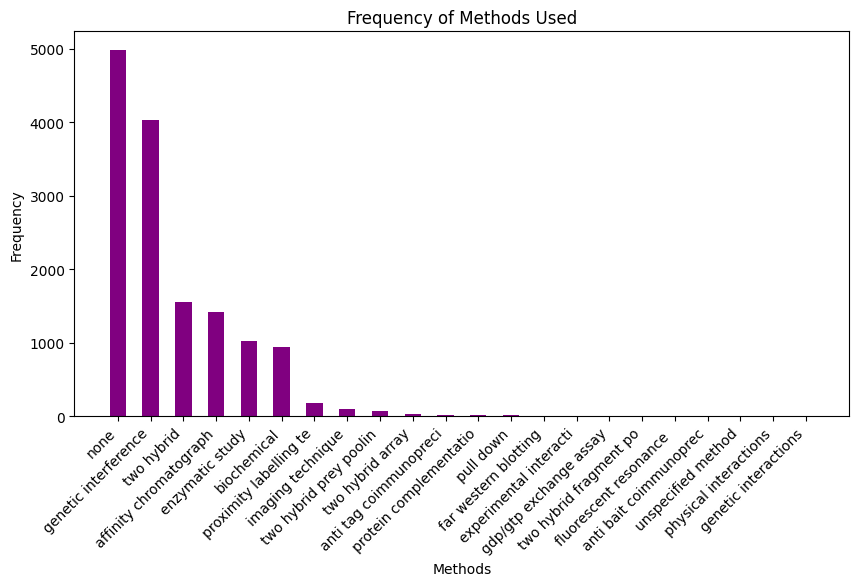

In [95]:
# Methods
interaction_method_count = candidate_gene_edge_df['interaction_method'].value_counts()

methods = list(candidate_gene_edge_df['interaction_method'].unique())
frequencies = [count for method, count in interaction_method_count.items()]
plt.figure(figsize=(10,5))


plt.bar(methods, frequencies, color = 'purple', width = 0.5)

plt.xlabel("Methods")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right',fontsize=10)
plt.title("Frequency of Methods Used")
plt.show()

For interaction types, Association is still first, but genetic enhancement is second (whereas in the main dataset, genetic enhancement is 11th)

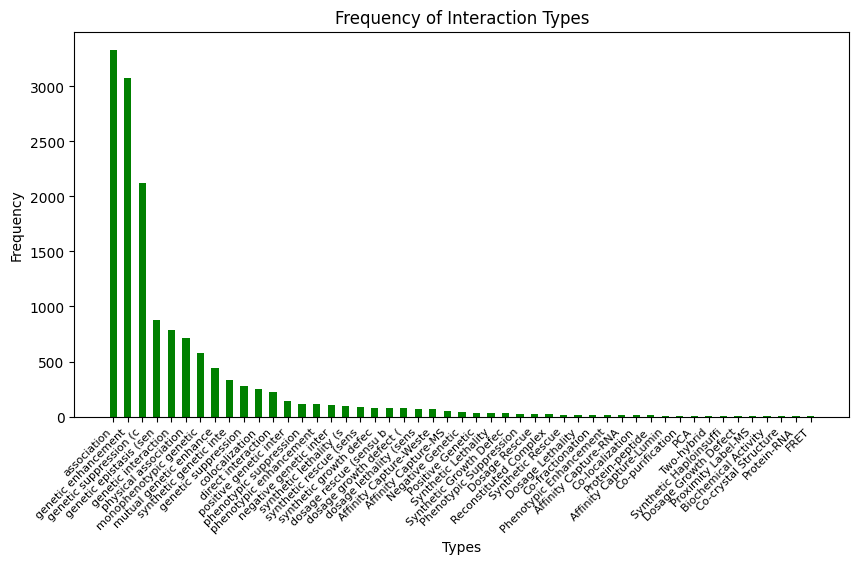

In [100]:
# Interaction Types
interaction_type_count = candidate_gene_edge_df['interaction_type'].value_counts()

types = list(candidate_gene_edge_df['interaction_type'].unique())
frequencies = [count for inttype, count in interaction_type_count.items()]
plt.figure(figsize=(10,5))


plt.bar(types, frequencies, color = 'green', width = 0.5)

plt.xlabel("Types")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right',fontsize=8)
plt.title("Frequency of Interaction Types")
plt.show()

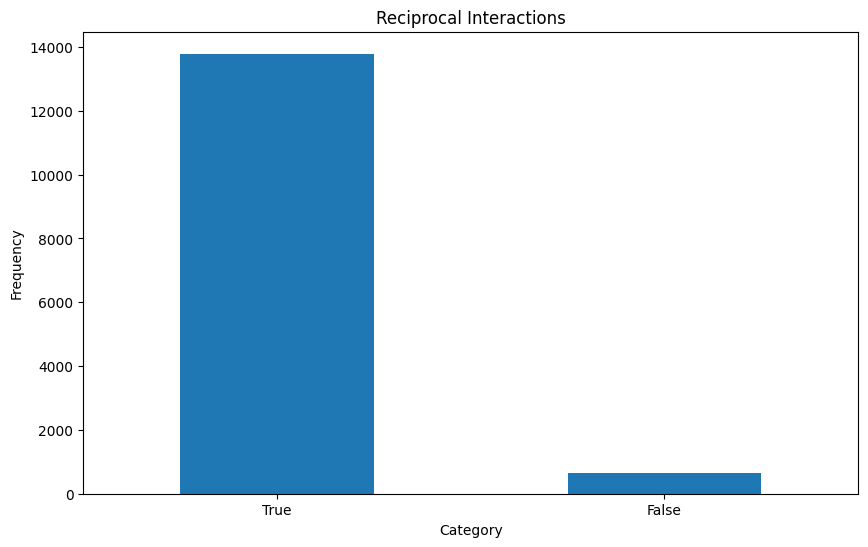

In [103]:
# Reciprocal

reciprocal = candidate_gene_edge_df['reciprocal'].value_counts()
plt.figure(figsize=(10, 6))
reciprocal.plot(kind='bar', color='tab:blue')
plt.title('Reciprocal Interactions')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# # Interaction count
# interaction_count_count = candidate_gene_edge_df['interaction_count'].value_counts()

# counts = list(candidate_gene_edge_df['interaction_count'].unique())
# frequencies = [count for method, count in interaction_count_count.items()]
# plt.figure(figsize=(10,5))


# plt.bar(counts, frequencies, color = 'green', width = 0.5)

# plt.xlabel("Interaction Counts")
# plt.ylabel("Frequency")
# plt.xticks(fontsize=10)
# plt.title("Frequency of Interaction Counts")
# plt.show()